In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor,VotingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from xgboost import XGBRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor 
from sklearn.metrics import mean_squared_error
#import optuna
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate, KFold,TimeSeriesSplit,PredefinedSplit
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
#import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import ElasticNet, Lasso
import lightgbm as lgb
#import torch
#import torch.nn as nn
#import torch.optim as optim
#from tqdm import tqdm
#from optuna.pruners import MedianPruner
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.datasets import make_regression
from scipy import stats
from sklearn.metrics import r2_score 
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.tsa.seasonal import STL
from scipy.optimize import curve_fit
from scipy.signal import detrend
from sklearn.linear_model import LinearRegression
import shap
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from hmmlearn.hmm import GaussianHMM # <-- Import HMM
import warnings
warnings.filterwarnings("ignore")

In [29]:
train_file_path = "hull-tactical-market-prediction/train.csv"
test_file_path = "hull-tactical-market-prediction/test.csv"
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
print("Full train dataset shape is {}".format(train_df.shape))

Full train dataset shape is (8990, 98)


In [30]:
def categorize_features(df):
    """Categorize features based on their prefixes"""
    
    print("\n🏷️ FEATURE CATEGORIZATION")
    print("="*50)
    
    feature_categories = {}
    
    # Define feature categories based on prefixes
    categories = {
        'Market_Dynamics': 'M',
        'Macro_Economic': 'E',
        'Interest_Rate': 'I',
        'Price_Valuation': 'P',
        'Volatility': 'V',
        'Sentiment': 'S',
        'Momentum': 'MOM',
        'Dummy_Binary': 'D'
    }
    
    # Categorize features
    for category, prefix in categories.items():
        if prefix == 'MOM':
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix)]
        else:
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix) and not col.startswith('MOM')]
    
    # Special columns
    special_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    feature_categories['Special'] = [col for col in special_cols if col in df.columns]
    
    # Display categorization
    total_features = 0
    for category, features in feature_categories.items():
        print(f"📊 {category}: {len(features)} features")
        total_features += len(features)
    
    print(f"\n📈 Total categorized features: {total_features}")
    print(f"📈 Total columns in dataset: {df.shape[1]}")
    
    return feature_categories

feature_categories = categorize_features(train_df)


🏷️ FEATURE CATEGORIZATION
📊 Market_Dynamics: 18 features
📊 Macro_Economic: 20 features
📊 Interest_Rate: 9 features
📊 Price_Valuation: 13 features
📊 Volatility: 13 features
📊 Sentiment: 12 features
📊 Momentum: 0 features
📊 Dummy_Binary: 9 features
📊 Special: 4 features

📈 Total categorized features: 98
📈 Total columns in dataset: 98


In [6]:
def analyze_feature_importance(df, feature_categories, max_features=100):
    """Analyze feature importance using various methods"""
    
    print("\n⭐ FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    if 'forward_returns' not in df.columns:
        print("❌ No target variable found for feature importance analysis")
        return
    
    # Prepare data - remove non-feature columns
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features)
    
    # Limit features for computational efficiency
    if len(feature_cols) > max_features:
        feature_cols = feature_cols[:max_features]
        print(f"⚠️ Limited to first {max_features} features for computational efficiency")
    
    # Create feature matrix
    X = df[feature_cols].fillna(0)
    y = df['forward_returns'].fillna(0)
    
    # Remove rows where target is missing
    mask = ~df['forward_returns'].isna()
    X = X[mask]
    y = y[mask]
    if len(X) == 0:
        print("❌ No valid data for feature importance analysis")
        return
    
    print(f"📊 Analyzing {len(feature_cols)} features with {len(X)} samples")
    
    # 1. Correlation-based importance
    corr_importance = abs(X.corrwith(y)).sort_values(ascending=False)
    
    # 2. Mutual Information
    try:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        mi_importance = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
    except:
        print("⚠️ Mutual information calculation failed")
        mi_importance = pd.Series(index=feature_cols)
    
    # Combine results
    importance_df = pd.DataFrame({
        'Correlation': corr_importance,
        'Mutual_Info': mi_importance
    }).fillna(0)
    
    # Create composite score
    importance_df['Composite_Score'] = (
        importance_df['Correlation'].rank(pct=True) + 
        importance_df['Mutual_Info'].rank(pct=True)
    ) / 2
    
    importance_df = importance_df.sort_values('Composite_Score', ascending=False)
    
    print("\n🏆 TOP 50 MOST IMPORTANT FEATURES:")
    display(importance_df.head(10))
    
    return importance_df

importance_results = analyze_feature_importance(train_df, feature_categories)


⭐ FEATURE IMPORTANCE ANALYSIS
📊 Analyzing 94 features with 8990 samples

🏆 TOP 50 MOST IMPORTANT FEATURES:


,Correlation,Mutual_Info,Composite_Score
V13,0.060394,0.080330,0.978723
V7,0.031311,0.109882,0.968085
E19,0.023786,0.105646,0.936170
P5,0.021950,0.072423,0.898936
S5,0.038868,0.047288,0.861702
M17,0.023147,0.048060,0.813830
S2,0.036258,0.042327,0.803191
V9,0.012537,0.066261,0.792553
E11,0.029054,0.043058,0.787234
S8,0.008964,0.089482,0.781915


In [7]:
print(importance_results.index)

Index(['V13', 'V7', 'E19', 'P5', 'S5', 'M17', 'S2', 'V9', 'E11', 'S8', 'M4',
       'E12', 'I2', 'P8', 'E18', 'M18', 'V10', 'E6', 'I9', 'E9', 'E16', 'P10',
       'I5', 'M1', 'M12', 'E17', 'M8', 'E15', 'M10', 'V6', 'V1', 'P7', 'P12',
       'M5', 'M2', 'P11', 'I4', 'I3', 'E8', 'S7', 'M3', 'S9', 'V5', 'M11',
       'M7', 'E1', 'E2', 'E20', 'D1', 'D2', 'V12', 'E3', 'S12', 'D8', 'D4',
       'M14', 'S6', 'S3', 'P2', 'E7', 'E10', 'V8', 'D6', 'E5', 'P6', 'I7',
       'D5', 'S10', 'S1', 'D7', 'V11', 'P3', 'M13', 'P4', 'E13', 'I1', 'P9',
       'S4', 'M6', 'M16', 'M9', 'I8', 'D3', 'E4', 'I6', 'E14', 'M15', 'P13',
       'V4', 'S11', 'P1', 'V2', 'V3', 'D9'],
      dtype='object')


In [31]:
TARGET = "market_forward_excess_returns"
FEATURES = [col for col in train_df.columns if col not in [TARGET]]
X = train_df[FEATURES].copy()
X['forward_returns_lag'] = X['forward_returns'].shift(1)
X['risk_free_rate_lag'] = X['risk_free_rate'].shift(1)
X.drop('forward_returns', axis = 1, inplace = True)
X.drop('risk_free_rate', axis =1, inplace = True)
y = train_df[TARGET]
#X.fillna(0, inplace=True)

N_TEST_ROWS = 63
X_test = X.iloc[-N_TEST_ROWS:]
y_test = y.iloc[-N_TEST_ROWS:]
X = X.iloc[:-N_TEST_ROWS]
y = y.iloc[:-N_TEST_ROWS]

print("Full train dataset shape is {}".format(X.shape))
print(X.columns)
print(X.isna().any().sum())
print(y.isna().any().sum())

Full train dataset shape is (8927, 97)
Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
       'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3',
       'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13',
       'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns_lag',
       'risk_free_rate_lag'],
      dtype='object')
87
0


In [9]:
'''
# --- 假设 sharpe_ratio_scorer 和数据 X, y 已经定义 ---
# def sharpe_ratio_scorer(estimator, X, y):
#     ... (你的评分函数) ...

def cat_objective(trial, X, y):
    """
    Optuna 的目标函数，用于优化 CatBoost 模型的超参数，
    直接最大化基于时间序列交叉验证的夏普比率。
    """
    # 1. 定义超参数搜索空间 (与你的代码相同)
    params = {
    # 基础设置
    'objective': 'RMSE',
    'verbose': 0,
    
    # --- 核心优化：更激进的正则化和随机性 ---

    # 1. 迭代次数和学习率：慢工出细活
    # 增加迭代次数上限，配合更小的学习率，让模型有更多时间“思考”，稳定收敛
    'iterations': trial.suggest_int('iterations', 300, 2400),
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.03, log=True),

    # 2. 树结构：限制复杂度，防止过拟合
    # 减小树的最大深度，对于小数据，更深的树极易过拟合
    'depth': trial.suggest_int('depth', 4, 7),
    # 增加叶子节点的最小样本数，进一步限制树的生长
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 40),

    # 3. L2正则化：更强的“紧箍咒”
    # 提高L2正则的下限，对小数据施加更强的惩罚，防止权重过大
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5.0, 10.0, log=True),

    # 4. 随机性注入：核心武器
    # 显著提高random_strength的上限，强迫模型在选择分裂点时引入更多随机性
    # 这能有效打破过拟合的恶性循环，是应对高噪声数据的关键
    'random_strength': trial.suggest_float('random_strength', 1.0, 10.0, log=True),
    
    # 5. 特征采样：增加模型鲁棒性
    # 在树的每个层级随机采样一部分特征，防止模型过度依赖少数“看似重要”的特征
    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),

    # 早停策略：保持不变或适当放宽
    # 对于小数据，验证集的波动可能较大，过早停止可能错过潜在的好模型
    'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50,100)
    }

        
    # 2. 交叉验证设置 (已修正为 TimeSeriesSplit)
    # n_splits=5 意味着会进行 5 次验证，每次用较新的数据作为验证集
    tscv = TimeSeriesSplit(n_splits=5)
    scorers = {
        'sharpe': sharpe_ratio_scorer,
        'r2': 'r2' 
    }
    
    # 3. 训练模型并计算交叉验证分数
    model = CatBoostRegressor(**params)
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # 安全中位数填充
        ('regressor', model)
    ])
    
    scores = cross_validate(
        pipeline,
        X, 
        y, 
        cv=tscv,  # 使用时间序列交叉验证
        scoring=scorers, # 使用你的自定义评分函数
        n_jobs=-1
    )
    
    # 4. 计算平均夏普比率并返回
    # Optuna 会自动最大化这个返回值
    mean_sharpe = np.mean(scores['test_sharpe'])
    mean_r2 = np.mean(scores['test_r2'])
    print(f"Trial {trial.number} | Mean Sharpe: {mean_sharpe:.4f} | Mean R²: {mean_r2:.4f}")
    
    return mean_sharpe

# --- 如何使用 ---
# study = optuna.create_study(direction='maximize') # 明确指定优化方向是最大化
# study.optimize(lambda trial: cat_objective(trial, X, y), n_trials=50)
# print("Best parameters:", study.best_params)
# print("Best Sharpe Ratio:", study.best_value)
'''

'\n# --- 假设 sharpe_ratio_scorer 和数据 X, y 已经定义 ---\n# def sharpe_ratio_scorer(estimator, X, y):\n#     ... (你的评分函数) ...\n\ndef cat_objective(trial, X, y):\n    """\n    Optuna 的目标函数，用于优化 CatBoost 模型的超参数，\n    直接最大化基于时间序列交叉验证的夏普比率。\n    """\n    # 1. 定义超参数搜索空间 (与你的代码相同)\n    params = {\n    # 基础设置\n    \'objective\': \'RMSE\',\n    \'verbose\': 0,\n\n    # --- 核心优化：更激进的正则化和随机性 ---\n\n    # 1. 迭代次数和学习率：慢工出细活\n    # 增加迭代次数上限，配合更小的学习率，让模型有更多时间“思考”，稳定收敛\n    \'iterations\': trial.suggest_int(\'iterations\', 300, 2400),\n    \'learning_rate\': trial.suggest_float(\'learning_rate\', 1e-4, 0.03, log=True),\n\n    # 2. 树结构：限制复杂度，防止过拟合\n    # 减小树的最大深度，对于小数据，更深的树极易过拟合\n    \'depth\': trial.suggest_int(\'depth\', 4, 7),\n    # 增加叶子节点的最小样本数，进一步限制树的生长\n    \'min_data_in_leaf\': trial.suggest_int(\'min_data_in_leaf\', 1, 40),\n\n    # 3. L2正则化：更强的“紧箍咒”\n    # 提高L2正则的下限，对小数据施加更强的惩罚，防止权重过大\n    \'l2_leaf_reg\': trial.suggest_float(\'l2_leaf_reg\', 5.0, 10.0, log=True),\n\n    # 4. 随机性注入：核心武器\n    # 显著提高

In [10]:
'''
from optuna.samplers import TPESampler

n_trials=20
with tqdm(total=n_trials, desc="Optuna Optimization") as pbar:
    
    # 3. 定义一个回调函数来更新进度条
    def update_progress(study, trial):
        pbar.update(1)

    # 4. 创建 Study
    study = optuna.create_study(direction='maximize',pruner=MedianPruner(n_warmup_steps=10))
    
    # 5. 在 optimize 中传入 callbacks
    study.optimize(
        lambda trial: cat_objective(trial, X, y),
        n_trials=n_trials,
        callbacks=[update_progress], # <--- 传入回调函数
        n_jobs=-1
    )

print("Best parameters:", study.best_params)
print("Best Sharpe Ratio:", study.best_value)
'''

'\nfrom optuna.samplers import TPESampler\n\nn_trials=20\nwith tqdm(total=n_trials, desc="Optuna Optimization") as pbar:\n\n    # 3. 定义一个回调函数来更新进度条\n    def update_progress(study, trial):\n        pbar.update(1)\n\n    # 4. 创建 Study\n    study = optuna.create_study(direction=\'maximize\',pruner=MedianPruner(n_warmup_steps=10))\n\n    # 5. 在 optimize 中传入 callbacks\n    study.optimize(\n        lambda trial: cat_objective(trial, X, y),\n        n_trials=n_trials,\n        callbacks=[update_progress], # <--- 传入回调函数\n        n_jobs=-1\n    )\n\nprint("Best parameters:", study.best_params)\nprint("Best Sharpe Ratio:", study.best_value)\n'

In [32]:
cat_parameters = {'iterations': 763, 
                   'learning_rate': 0.0038870372409991727, 
                   'depth': 5, 
                   'min_data_in_leaf': 19, 
                   'l2_leaf_reg': 5.3508021334737075, 
                   'random_strength': 5.350519385076495, 
                   'colsample_bylevel': 0.8572279797295979, 
                   'early_stopping_rounds': 50}

In [33]:
cat_parameters2 = {'iterations': 800, 
                   'learning_rate': 0.004,
                   'depth': 5, 
                   'min_data_in_leaf': 19, 
                   'l2_leaf_reg': 5.4,
                   'random_strength': 5.2, 
                   'colsample_bylevel': 0.86, 
                   'early_stopping_rounds': 50}

In [13]:
xgb_params = {
    'objective': 'reg:squarederror',  # 假设是回归任务，如果是分类请更改
    'eval_metric': 'rmse',             # 同样，根据任务选择评估指标
    'n_estimators': 763,
    'learning_rate': 0.0038870372409991727,
    'max_depth': 5,
    'min_child_weight': 19,
    'reg_lambda': 5.3508021334737075,
    'colsample_bylevel': 0.8572279797295979,
    
    # --- 新增/推荐的 XGBoost 参数 ---
    'gamma': 0.1,  # 作为 random_strength 的一种替代，用于控制分裂的保守程度，需要调优
    'subsample': 0.8, # 建议加入，对训练样本进行采样，增强模型稳健性
    'colsample_bytree': 0.8, # 建议加入，这是XGBoost更常用的特征采样参数
    
    'n_jobs': -1,  # 使用所有CPU核心
    'seed': 42     # 设置随机种子以保证结果可复现
}

In [34]:
def ad_sharpe_ratio_scorer(y_pred, y):
    
    y_pred = y_pred.astype(float)
    y_true = y.astype(float)
    
    # 3. 计算策略的每日收益
    # 策略逻辑：预测为正时买入，预测为负时不操作
    positions = np.where(y_pred > 0, y_pred, 0)
    #positions = np.clip(positions, 0, 2)
    strategy_returns = positions * y_true
    
    # 4. 计算夏普比率
    mean_return = np.mean(strategy_returns)
    std_return = np.std(strategy_returns)
    
    # 增加一个小的 epsilon 以避免除以零
    epsilon = 1e-8
    sharpe_ratio = mean_return / (std_return + epsilon)
    
    # 5. 返回夏普比率。scikit-learn 会尝试最大化这个值。
    return sharpe_ratio

In [35]:
class DataFrameWrapper(BaseEstimator, TransformerMixin):
    """
    一个包装器，用于包裹 scikit-learn 的转换器 (如 SimpleImputer)，
    以确保其输出 *始终* 是一个 Pandas DataFrame。
    """
    def __init__(self, transformer):
        self.transformer = transformer
        
    def fit(self, X, y=None):
        """
        在 fit 期间，学习 X_train 的列名，
        并拟合内部的 transformer。
        """
        # (假设 X 是一个 DataFrame)
        self.columns_ = X.columns
        self.index_ = X.index
        
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        """
        在 transform 期间，调用内部的 transformer，
        然后立即将 NumPy 输出重建回 DataFrame。
        """
        # X 可能是 X_train 或 X_test
        
        # 1. 内部 transformer (例如 SimpleImputer) 输出 NumPy
        numpy_output = self.transformer.transform(X)
        
        # 2. 立即重建 DataFrame
        #    使用在 .fit() 期间学到的列名
        #    使用 .transform(X) 中传入的 X 的索引
        df_output = pd.DataFrame(
            numpy_output,
            columns=self.columns_,
            index=X.index
        )
        
        return df_output

In [36]:
def create_drop_features(df: pd.DataFrame) -> pd.DataFrame:
    global log1
    df_out = df.copy()

    SEP_cols = ['date_id','forward_returns', 'risk_free_rate']
    N_I_features = importance_results.tail(10).index.tolist()
    COLS_TO_DROP =  ['date_id','E7', 'V10', 'S3', 'M1', 'M13','M14','M6','V9'] + N_I_features
    df_out.drop(columns = [col for col in COLS_TO_DROP if col in df_out.columns], inplace = True)
    
    if (log1):
        pprint(f"Feature X: {df_out.columns.tolist()}")
        print(f"Feature Creator Output Shape: {df_out.shape}")
        log1 = False
    return df_out

In [94]:
# columns to keep after feature engineering
I_cols = ['M4_roll_mean_5', 'M4', 'V13', 'M4_lag_1', 'S12', 'forward_returns_lag_roll_mean_5', 'S5_lag_1', 
     'S5_roll_mean_20', 'forward_returns_lag', 'I2', 'S2', 'P7', 'P5', 'M17', 'S2_lag_1', 'feat_M4_div_V13', 
     'M2', 'S5', 'V7', 'S5_roll_mean_60', 'S2_roll_std_60', 'M17_lag_1', 'V12', 'M17_lag_5', 'M11', 'forward_returns_lag_lag_1', 
     'M8', 'M17_lag_20', 'S2_roll_mean_5', 'S2_roll_mean_20', 'E19_roll_std_5', 'E11', 'P10', 'V8', 'forward_returns_lag_roll_mean_60', 
     'M17_roll_mean_20', 'M12', 'E11_roll_std_20', 'E11_lag_20', 'S5_roll_mean_5']


def create_drop_features2(df: pd.DataFrame) -> pd.DataFrame:
    global log2
    my_I_cols = I_cols.copy()
    df_out = df.copy()
    
    TOP_FEATURES= ['forward_returns_lag','M4','M17','S5','S2','E19','E11']
    SEP_cols = ['date_id', 'forward_returns', 'risk_free_rate']
    LAG_PERIODS = [1, 5, 20]
    ROLLING_WINDOWS = [5, 20, 60]
    N_I_features = importance_results.tail(20).index.tolist()
    COLS_TO_DROP =  ['date_id','E7', 'V10', 'S3', 'M1', 'M13','M14','M6','V9', 'risk_free_rate_lag'] + N_I_features
    features_dict = {}
                
    for col in TOP_FEATURES:
        if col in df_out.columns:
            for lag in LAG_PERIODS:
                features_dict[f'{col}_lag_{lag}'] = df_out[col].shift(lag)
            for window in ROLLING_WINDOWS:
                features_dict[f'{col}_roll_mean_{window}'] = df_out[col].rolling(window=window, min_periods=1).mean()
                features_dict[f'{col}_roll_std_{window}'] = df_out[col].rolling(window=window, min_periods=1).std()
                
    df_out = pd.concat([df_out, pd.DataFrame(features_dict)], axis=1)
    epsilon = 1e-6 # 防止除以零
    
    # 我们需要的最强特征: M4_roll_mean_20, V13, S12
    # (确保这些特征存在于 df_out 中，即它们不是来自被丢弃的列)
    
    # 1. 风险调整后动量 (M4 趋势 vs. V13 波动性)
    if 'M4_roll_mean_20' in df_out.columns and 'V13' in df_out.columns:
        df_out['feat_M4_div_V13'] = df_out['M4_roll_mean_20'] / (df_out['V13'] + epsilon)
        
        
    # find all column name that start with regime and add them to I_cols
    regime_cols = [col for col in df_out.columns if col.startswith('regime')]
    for col in regime_cols:
        if col not in my_I_cols:
            my_I_cols.append(col)

    df_out.drop(columns = [col for col in COLS_TO_DROP if col in df_out.columns], inplace = True)
    df_out = df_out[my_I_cols]
    if (log2):
        pprint(f"Feature X: {df_out.columns.tolist()}")
        print(f"Feature Creator Output Shape: {df_out.shape}")
        log2 = False
    return df_out

In [95]:
feature_creator = FunctionTransformer(create_drop_features, validate=False)
feature_creator2 = FunctionTransformer(create_drop_features2, validate=False)

## create cluster

In [96]:
class create_cluster(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_categories, window=50, n_clusters=None):
        self.feature_categories = feature_categories
        self.window = window
        self.n_clusters = n_clusters

    def _detrend_and_standardize(self, df):
        """
        Detrend and standardize features based on their categories.
        Price/Economic series: absolute change
        Indicators: rolling Z-score
        """
        df_transformed = df.copy()
        window = self.window # 从类属性获取窗口大小
        
        for category, features in self.feature_categories.items():
            # 确保只处理存在的列
            features = [f for f in features if f in df_transformed.columns]
            
            if category in ['Price_Valuation', 'Macro_Economic']:
                # Absolute change for price/economic series
                for feature in features:
                    df_transformed[feature] = df_transformed[feature].diff().fillna(0)
                    
            elif category not in ['Dummy_Binary', 'Special']:
                # Rolling Z-score for indicators
                for feature in features:
                    rolling_mean = df_transformed[feature].rolling(window=window).mean()
                    rolling_std = df_transformed[feature].rolling(window=window).std()
                    
                    # 用 1.0 替换 0，以防止除以零
                    rolling_std.replace(0.0, 1.0, inplace=True) 
                    
                    df_transformed[feature] = (df_transformed[feature] - rolling_mean) / rolling_std
                    
                    # 填充滚动的 Z-Score 产生的 NaN
                    df_transformed[feature] = df_transformed[feature].fillna(0)
            
            # Dummy_Binary 和 Special 类别被自动跳过
            
        return df_transformed
    # ----------------------------------------------------------------------

    def fit(self, X, y=None):
        # 1. 准备要聚类的特征列
        feature_cols = []
        for category, features in self.feature_categories.items():
            if category != 'Special':
                feature_cols.extend(features)
        
        self.feature_cols = [f for f in feature_cols if f in X.columns]
        X_cluster = X[self.feature_cols]
        
        # 2. Imputer (仍然需要，以防原始数据有 NaN)
        self.imputer = SimpleImputer(strategy='median').set_output(transform="pandas")
        X_imputed = self.imputer.fit_transform(X_cluster)
        
        # 3. 应用集成的 detrend 和 standardize 方法
        X_processed = self._detrend_and_standardize(X_imputed)
        
        if self.n_clusters is None:
            # 4. 寻找最佳 K
            silhouette_scores = []
            k_range = range(2, 11)  # 固定的、安全的范围
            
            for k in k_range:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                cluster_labels = kmeans.fit_predict(X_processed.values)
                silhouette_avg = silhouette_score(X_processed.values, cluster_labels)
                silhouette_scores.append(silhouette_avg)
            
            self.optimal_k = k_range[np.argmax(silhouette_scores)]
            print(f"\nOptimal number of clusters (Detrended): {self.optimal_k}")
        else:
            self.optimal_k = self.n_clusters
            print(f"\nUsing specified number of clusters (Detrended): {self.optimal_k}")

        # 5. 训练最终的 KMeans 模型
        self.kmeans = KMeans(n_clusters=self.optimal_k, random_state=42, n_init=10)
        self.kmeans.fit(X_processed.values)
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        
        # 1. 仅选择相关列
        X_cluster = X[self.feature_cols]
        
        # 2. 应用 *已
        # 训练* 的 Imputer
        X_imputed = self.imputer.transform(X_cluster)
        
        # 3. 应用 *相同* 的 detrend 和 standardize 转换
        X_processed = self._detrend_and_standardize(X_imputed)
        
        # 4. 应用 *已训练* 的 KMeans
        cluster_labels = self.kmeans.predict(X_processed.values)
        
        X_transformed["cluster"] = cluster_labels
        return X_transformed

## create HMM cluster

In [111]:
class create_hmm_regime(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_categories, window=50, n_regimes=None, 
                 max_regimes=24, metric_for_k='bic', predict_type='proba',
                 n_inits=3, # <-- NEW: Number of times to re-fit
                 random_state=42):
        """
        __init__ modified for HMM.
        
        n_clusters -> n_regimes: The number of hidden states (regimes).
        max_regimes: The max number to search if n_regimes is None.
        metric_for_k: 'bic' or 'aic'. HMMs use likelihood-based metrics, not Silhouette.
        predict_type: 'proba' (recom'd) or 'labels'.
                      'proba' = probability of being in each regime (e.g., [0.1, 0.9, 0.0])
                      'labels' = the most likely regime (e.g., 1)
        """
        
        self.feature_categories = feature_categories
        self.window = window
        self.n_regimes = n_regimes
        self.max_regimes = max_regimes
        self.metric_for_k = metric_for_k
        self.predict_type = predict_type
        self.n_inits = n_inits # <-- NEW
        self.random_state = random_state

    def _detrend_and_standardize(self, df):
        # This function is unchanged.
        df_transformed = df.copy()
        window = self.window
        for category, features in self.feature_categories.items():
            features = [f for f in features if f in df_transformed.columns]
            if category in ['Price_Valuation', 'Macro_Economic']:
                for feature in features:
                    df_transformed[feature] = df_transformed[feature].diff().fillna(0)
            elif category not in ['Dummy_Binary', 'Special']:
                for feature in features:
                    rolling_mean = df_transformed[feature].rolling(window=window).mean()
                    rolling_std = df_transformed[feature].rolling(window=window).std()
                    rolling_std.replace(0.0, 1.0, inplace=True) 
                    df_transformed[feature] = (df_transformed[feature] - rolling_mean) / rolling_std
                    df_transformed[feature] = df_transformed[feature].fillna(0)
        return df_transformed
    # ----------------------------------------------------------------------

    def fit(self, X, y=None):
        # 1. & 2. & 3. Preprocessing (unchanged)
        feature_cols = []
        for category, features in self.feature_categories.items():
            if category != 'Special':
                feature_cols.extend(features)
        
        self.feature_cols = [f for f in feature_cols if f in X.columns]
        X_cluster = X[self.feature_cols]
        self.imputer = SimpleImputer(strategy='median').set_output(transform="pandas")
        X_imputed = self.imputer.fit_transform(X_cluster)
        X_processed = self._detrend_and_standardize(X_imputed)
        X_fit_data = X_processed.values[self.window:]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            if self.n_regimes is None:
                # 4. Find optimal 'k' (NOW MORE ROBUST)
                scores = []
                k_range = range(2, self.max_regimes + 1)
                
                for k in k_range:
                    best_k_score = np.inf
                    # Try n_inits times for this 'k'
                    for i in range(self.n_inits):
                        try:
                            hmm = GaussianHMM(n_components=k, 
                                              random_state=self.random_state + i, # Use different seed
                                              covariance_type="diag", n_iter=100)
                            hmm.fit(X_fit_data)
                            
                            score = hmm.bic(X_fit_data) if self.metric_for_k == 'bic' else hmm.aic(X_fit_data)
                            
                            if score < best_k_score:
                                best_k_score = score
                        except ValueError:
                            pass # Fit failed, ignore this init
                    
                    scores.append(best_k_score)
                
                self.optimal_regimes = k_range[np.argmin(scores)]
                print(f"\nOptimal number of regimes ({self.metric_for_k}): {self.optimal_regimes}")
            else:
                self.optimal_regimes = self.n_regimes
                print(f"\nUsing specified number of regimes: {self.optimal_regimes}")

            # 5. Train final HMM (NOW MORE ROBUST)
            best_final_score = -np.inf
            best_hmm = None
            
            # Try n_inits times for the final model
            for i in range(self.n_inits):
                try:
                    hmm = GaussianHMM(n_components=self.optimal_regimes, 
                                      random_state=self.random_state + i, # Use different seed
                                      covariance_type="diag", n_iter=100)
                    hmm.fit(X_fit_data)
                    
                    # We use the raw log-likelihood score to find the best fit
                    score = hmm.score(X_fit_data) 
                    
                    if score > best_final_score:
                        best_final_score = score
                        best_hmm = hmm
                except ValueError:
                    pass # Fit failed
            
            self.hmm = best_hmm # Save the best model found
            
        if self.hmm is None:
             raise RuntimeError("HMM fitting failed for all initializations.")
                
        return self
        
    def transform(self, X):
        # This function is unchanged
        X_transformed = X.copy()
        X_cluster = X[self.feature_cols]
        X_imputed = self.imputer.transform(X_cluster)
        X_processed = self._detrend_and_standardize(X_imputed)
        X_processed_values = X_processed.values

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if self.predict_type == 'proba':
                probas = self.hmm.predict_proba(X_processed_values)
                proba_cols = [f"regime_{i}_prob" for i in range(self.optimal_regimes)]
                X_transformed[proba_cols] = probas
            else:
                labels = self.hmm.predict(X_processed_values)
                X_transformed["regime"] = labels
            
        return X_transformed

## train

In [115]:
import matplotlib.pyplot as plt

IMPUTER_PARAMETERS = {
    'n_neighbors': 10,             
    'weights': 'uniform',         
    'missing_values': np.nan     
}
KNN_IMPUTER = KNNImputer(**IMPUTER_PARAMETERS)
KNN_IMPUTER2 = KNNImputer(**IMPUTER_PARAMETERS)

preprocessor_pipeline1 = Pipeline([
    ('feature_creator', feature_creator),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor_pipeline2 = Pipeline([
    ('cluster', create_hmm_regime(feature_categories = feature_categories, max_regimes=12)),
    ('feature_creator', feature_creator2),
    ('imputer', DataFrameWrapper(SimpleImputer(strategy='constant', fill_value=0))),
    #('scaler', DataFrameWrapper(RobustScaler())),
])

model1 = CatBoostRegressor(**cat_parameters2, verbose=0, random_seed=42)
model2 = CatBoostRegressor(**cat_parameters2, verbose=0, random_seed=42)
n_trials = 5
print(f"\n开始执行前向展开分析...{n_trials} times")

log1 = True
log2 = True
base_model_descirption = "Base Line"
new_model_descirption = "90 top features with window and rolling"
n_trials = 5

n_samples = len(X)
initial_train_size = int(n_samples * 0.5)
test_size = int(n_samples * 0.1)

# --- (您现有的列表) ---
base_model_sharpe_scores, new_model_sharpe_scores = [], []
base_model_r2_scores, new_model_r2_scores = [], []
base_model_hit_rate, new_model_hit_rate = [], []
all_test_indices, all_y_true, all_base_preds, all_new_preds = [], [], [], []

# --- 
# ✅ 新增：为“解耦”的 SHAP 分析创建列表
# ---
all_shap_values_new = []  # 存储每个周期的 SHAP 值
all_X_val_new = []        # 存储每个周期的 X_val (用于绘图)

train_start_index = 0
train_end_index = initial_train_size
test_end_index = train_end_index + test_size

while test_end_index <= n_samples:
    print(f"训练周期: index {train_start_index} to {train_end_index-1} | "
          f"测试周期: index {train_end_index} to {test_end_index-1}")

    X_train, y_train = X.iloc[train_start_index:train_end_index], y.iloc[train_start_index:train_end_index]
    X_val, y_val = X.iloc[train_end_index:test_end_index], y.iloc[train_end_index:test_end_index]

    X_train_transformed1 = preprocessor_pipeline1.fit_transform(X_train)
    X_train_transformed2 = preprocessor_pipeline2.fit_transform(X_train)

    model1.fit(X_train_transformed1, y_train)
    model2.fit(X_train_transformed2, y_train)

    # 使用 tree_path_dependent 避免 SHAP 与 CatBoost 在传入背景数据时的已知问题
    # 并在计算时传入 numpy 数组，规避 DataFrame 兼容性差异
    explainer2 = shap.TreeExplainer(
        model2,
        feature_perturbation="tree_path_dependent"
    )

    X_val_transformed1 = preprocessor_pipeline1.transform(X_val)
    X_val_transformed2 = preprocessor_pipeline2.transform(X_val)

    preds_base = model1.predict(X_val_transformed1)
    preds_new = model2.predict(X_val_transformed2)

    # --- 
    # 步骤 1: 计算 SHAP (这一步必须在循环内)
    # ---
    shap_values_test2 = explainer2.shap_values(np.asarray(X_val_transformed2))
    base_model_sharpe_scores.append(ad_sharpe_ratio_scorer(preds_base, y_val))
    new_model_sharpe_scores.append(ad_sharpe_ratio_scorer(preds_new, y_val))
    base_model_r2_scores.append(r2_score(y_val, preds_base))
    new_model_r2_scores.append(r2_score(y_val, preds_new))
    base_model_hit_rate.append(np.mean(np.sign(y_val) == np.sign(preds_base)))
    new_model_hit_rate.append(np.mean(np.sign(y_val) == np.sign(preds_new)))
    
    # --- (您现有的绘图数据收集代码) ---
    all_test_indices.append(y_val.index)
    all_y_true.append(y_val.values)
    all_base_preds.append(preds_base)
    all_new_preds.append(preds_new)
    
    all_shap_values_new.append(shap_values_test2) # 附加 SHAP (Explanation 对象或数组)
    all_X_val_new.append(X_val_transformed2)      # 附加 DataFrame
    
    # --- (更新索引) ---
    train_start_index += test_size
    train_end_index += test_size
    test_end_index += test_size

# --- 循环结束 ---
print("\n前向展开分析完成。")
print(f"基础模型在各周期的夏普率: {[f'{s:.4f}' for s in base_model_sharpe_scores]}， 平均日夏普率：{np.mean(base_model_sharpe_scores)}")
print(f"新模型在各周期的夏普率:   {[f'{s:.4f}' for s in new_model_sharpe_scores]}， 平均日夏普率：{np.mean(new_model_sharpe_scores)}")
print("-" * 50)
print(f"基础模型在各周期的 R²: {[f'{s:.4f}' for s in base_model_r2_scores]}， 平均R2：{np.mean(base_model_r2_scores)}")
print(f"新模型在各周期的 R²:   {[f'{s:.4f}' for s in new_model_r2_scores]}， 平均R2：{np.mean(new_model_r2_scores)}")
print("-" * 50)
print(f"基础模型在各周期的 hit_rate: {[f'{s:.4f}' for s in base_model_hit_rate]}， 平均hit_rate：{np.mean(base_model_hit_rate)}")
print(f"新模型在各周期的 hit_rate:   {[f'{s:.4f}' for s in new_model_hit_rate]}， 平均hit_rate：{np.mean(new_model_hit_rate)}")


开始执行前向展开分析...5 times
训练周期: index 0 to 4462 | 测试周期: index 4463 to 5354
("Feature X: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'E1', 'E10', "
 "'E11', 'E12', 'E13', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', "
 "'E4', 'E5', 'E6', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I7', 'I8', "
 "'I9', 'M10', 'M11', 'M12', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', "
 "'M7', 'M8', 'M9', 'P10', 'P11', 'P12', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', "
 "'P8', 'P9', 'S1', 'S10', 'S12', 'S2', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', "
 "'V1', 'V11', 'V12', 'V13', 'V5', 'V6', 'V7', 'V8', 'forward_returns_lag', "
 "'risk_free_rate_lag']")
Feature Creator Output Shape: (4463, 78)


Model is not converging.  Current: 266397.31174234854 is not greater than 266404.05913936475. Delta is -6.747397016210016
Model is not converging.  Current: 129056.0498025461 is not greater than 129057.66771083126. Delta is -1.6179082851595012
Model is not converging.  Current: 129056.0498025461 is not greater than 129057.66771083126. Delta is -1.6179082851595012
Model is not converging.  Current: 310606.05354818463 is not greater than 310606.4636840191. Delta is -0.41013583447784185
Model is not converging.  Current: 310606.05354818463 is not greater than 310606.4636840191. Delta is -0.41013583447784185
Model is not converging.  Current: 319793.80263552675 is not greater than 319794.5006741253. Delta is -0.6980385985225439
Model is not converging.  Current: 319793.80263552675 is not greater than 319794.5006741253. Delta is -0.6980385985225439
Model is not converging.  Current: 346522.76350065734 is not greater than 346522.7904431045. Delta is -0.026942447177134454
Model is not converg


Optimal number of regimes (bic): 11


Model is not converging.  Current: 409991.0681573509 is not greater than 409991.9026440075. Delta is -0.8344866566476412


("Feature X: ['M4_roll_mean_5', 'M4', 'V13', 'M4_lag_1', 'S12', "
 "'forward_returns_lag_roll_mean_5', 'S5_lag_1', 'S5_roll_mean_20', "
 "'forward_returns_lag', 'I2', 'S2', 'P7', 'P5', 'M17', 'S2_lag_1', "
 "'feat_M4_div_V13', 'M2', 'S5', 'V7', 'S5_roll_mean_60', 'S2_roll_std_60', "
 "'M17_lag_1', 'V12', 'M17_lag_5', 'M11', 'forward_returns_lag_lag_1', 'M8', "
 "'M17_lag_20', 'S2_roll_mean_5', 'S2_roll_mean_20', 'E19_roll_std_5', 'E11', "
 "'P10', 'V8', 'forward_returns_lag_roll_mean_60', 'M17_roll_mean_20', 'M12', "
 "'E11_roll_std_20', 'E11_lag_20', 'S5_roll_mean_5', 'regime_0_prob', "
 "'regime_1_prob', 'regime_2_prob', 'regime_3_prob', 'regime_4_prob', "
 "'regime_5_prob', 'regime_6_prob', 'regime_7_prob', 'regime_8_prob', "
 "'regime_9_prob', 'regime_10_prob']")
Feature Creator Output Shape: (4463, 51)
训练周期: index 892 to 5354 | 测试周期: index 5355 to 6246
训练周期: index 892 to 5354 | 测试周期: index 5355 to 6246


Model is not converging.  Current: 11250.965192178406 is not greater than 11251.576610099884. Delta is -0.611417921478278
Model is not converging.  Current: -11398.053191881685 is not greater than -11396.530945090855. Delta is -1.5222467908297403
Model is not converging.  Current: -11398.053191881685 is not greater than -11396.530945090855. Delta is -1.5222467908297403
Model is not converging.  Current: -11396.144841193445 is not greater than -11394.862746168961. Delta is -1.2820950244840787
Model is not converging.  Current: -11396.144841193445 is not greater than -11394.862746168961. Delta is -1.2820950244840787
Model is not converging.  Current: 122579.87221058716 is not greater than 122579.87468776053. Delta is -0.0024771733733359724
Model is not converging.  Current: 122579.87221058716 is not greater than 122579.87468776053. Delta is -0.0024771733733359724
Model is not converging.  Current: 51801.886785159426 is not greater than 51807.36174611033. Delta is -5.474960950901732
Model


Optimal number of regimes (bic): 12


Model is not converging.  Current: 235378.10374577937 is not greater than 235378.38929082558. Delta is -0.28554504620842636
Model is not converging.  Current: 267026.37878531084 is not greater than 267026.3837701117. Delta is -0.004984800878446549
Model is not converging.  Current: 267026.37878531084 is not greater than 267026.3837701117. Delta is -0.004984800878446549
Model is not converging.  Current: 279118.3425115038 is not greater than 279118.375833105. Delta is -0.03332160122226924
Model is not converging.  Current: 279118.3425115038 is not greater than 279118.375833105. Delta is -0.03332160122226924


训练周期: index 1784 to 6246 | 测试周期: index 6247 to 7138


Model is not converging.  Current: -43615.14870334406 is not greater than -43608.00681607503. Delta is -7.141887269026483
Model is not converging.  Current: -62229.51517726771 is not greater than -62223.43505145645. Delta is -6.0801258112624055
Model is not converging.  Current: -62229.51517726771 is not greater than -62223.43505145645. Delta is -6.0801258112624055
Model is not converging.  Current: -59439.37063434459 is not greater than -59430.954436637396. Delta is -8.416197707192623
Model is not converging.  Current: -59439.37063434459 is not greater than -59430.954436637396. Delta is -8.416197707192623
Model is not converging.  Current: 79837.74501243581 is not greater than 79845.12737041131. Delta is -7.382357975497143
Model is not converging.  Current: 79837.74501243581 is not greater than 79845.12737041131. Delta is -7.382357975497143
Model is not converging.  Current: 80131.16412769705 is not greater than 80140.60082701124. Delta is -9.436699314188445
Model is not converging.  


Optimal number of regimes (bic): 11


Model is not converging.  Current: 237266.15155436148 is not greater than 237266.17009349604. Delta is -0.018539134558523074
Model is not converging.  Current: 228569.0260222202 is not greater than 228569.81151617062. Delta is -0.785493950417731
Model is not converging.  Current: 228569.0260222202 is not greater than 228569.81151617062. Delta is -0.785493950417731
Model is not converging.  Current: 221852.9030298937 is not greater than 221852.9166296544. Delta is -0.013599760713987052
Model is not converging.  Current: 221852.9030298937 is not greater than 221852.9166296544. Delta is -0.013599760713987052


训练周期: index 2676 to 7138 | 测试周期: index 7139 to 8030


Model is not converging.  Current: -62047.79692590736 is not greater than -62047.695061274266. Delta is -0.10186463309219107
Model is not converging.  Current: -74178.98817379311 is not greater than -74165.91965847487. Delta is -13.068515318242135
Model is not converging.  Current: -74178.98817379311 is not greater than -74165.91965847487. Delta is -13.068515318242135
Model is not converging.  Current: -62047.4651460309 is not greater than -62047.33658776348. Delta is -0.12855826742452336
Model is not converging.  Current: -62047.4651460309 is not greater than -62047.33658776348. Delta is -0.12855826742452336
Model is not converging.  Current: 30939.96524333743 is not greater than 30974.326916004622. Delta is -34.36167266719349
Model is not converging.  Current: 30939.96524333743 is not greater than 30974.326916004622. Delta is -34.36167266719349
Model is not converging.  Current: 29914.13208058547 is not greater than 29921.695620786693. Delta is -7.563540201223077
Model is not converg


Optimal number of regimes (bic): 12


Model is not converging.  Current: 143599.29789507246 is not greater than 143600.14582325006. Delta is -0.8479281775944401
Model is not converging.  Current: 159106.53491799816 is not greater than 159108.28425326108. Delta is -1.7493352629244328
Model is not converging.  Current: 159106.53491799816 is not greater than 159108.28425326108. Delta is -1.7493352629244328
Model is not converging.  Current: 157104.73395654146 is not greater than 157105.62999487616. Delta is -0.8960383347002789
Model is not converging.  Current: 157104.73395654146 is not greater than 157105.62999487616. Delta is -0.8960383347002789


训练周期: index 3568 to 8030 | 测试周期: index 8031 to 8922


Model is not converging.  Current: -92927.10150419078 is not greater than -92896.78736301581. Delta is -30.314141174967517
Model is not converging.  Current: -59224.25397751159 is not greater than -59223.885568869264. Delta is -0.36840864232362946
Model is not converging.  Current: -59224.25397751159 is not greater than -59223.885568869264. Delta is -0.36840864232362946
Model is not converging.  Current: -70293.36312355811 is not greater than -70289.93668237023. Delta is -3.4264411878830288
Model is not converging.  Current: -70293.36312355811 is not greater than -70289.93668237023. Delta is -3.4264411878830288
Model is not converging.  Current: -68829.75032836865 is not greater than -68819.7241855077. Delta is -10.02614286095195
Model is not converging.  Current: -68829.75032836865 is not greater than -68819.7241855077. Delta is -10.02614286095195
Model is not converging.  Current: -27922.863461142962 is not greater than -27916.90482190779. Delta is -5.958639235173905
Model is not con


Optimal number of regimes (bic): 12


Model is not converging.  Current: 72703.20597020275 is not greater than 72703.25323431926. Delta is -0.04726411651063245
Model is not converging.  Current: 58141.153362335426 is not greater than 58141.64972570851. Delta is -0.4963633730803849
Model is not converging.  Current: 58141.153362335426 is not greater than 58141.64972570851. Delta is -0.4963633730803849
Model is not converging.  Current: 53573.98902257829 is not greater than 53574.443103251135. Delta is -0.4540806728473399
Model is not converging.  Current: 53573.98902257829 is not greater than 53574.443103251135. Delta is -0.4540806728473399



前向展开分析完成。
基础模型在各周期的夏普率: ['0.0109', '0.0428', '0.0312', '0.0238', '0.0107']， 平均日夏普率：0.02389605499170634
新模型在各周期的夏普率:   ['0.0219', '0.0736', '0.0465', '0.0221', '0.0321']， 平均日夏普率：0.039236067219227524
--------------------------------------------------
基础模型在各周期的 R²: ['-0.0007', '0.0043', '-0.0015', '0.0006', '0.0005']， 平均R2：0.0006321555717792471
新模型在各周期的 R²:   ['0.0030', '0.0114', '0.0060', '-0.0005', '0.0028']， 平均R2：0.004541492801672953
--------------------------------------------------
基础模型在各周期的 hit_rate: ['0.4765', '0.5078', '0.5056', '0.5247', '0.4910']， 平均hit_rate：0.5011210762331838
新模型在各周期的 hit_rate:   ['0.5000', '0.5135', '0.5067', '0.5213', '0.4854']， 平均hit_rate：0.5053811659192825



--- 正在生成总体拟合图 ---


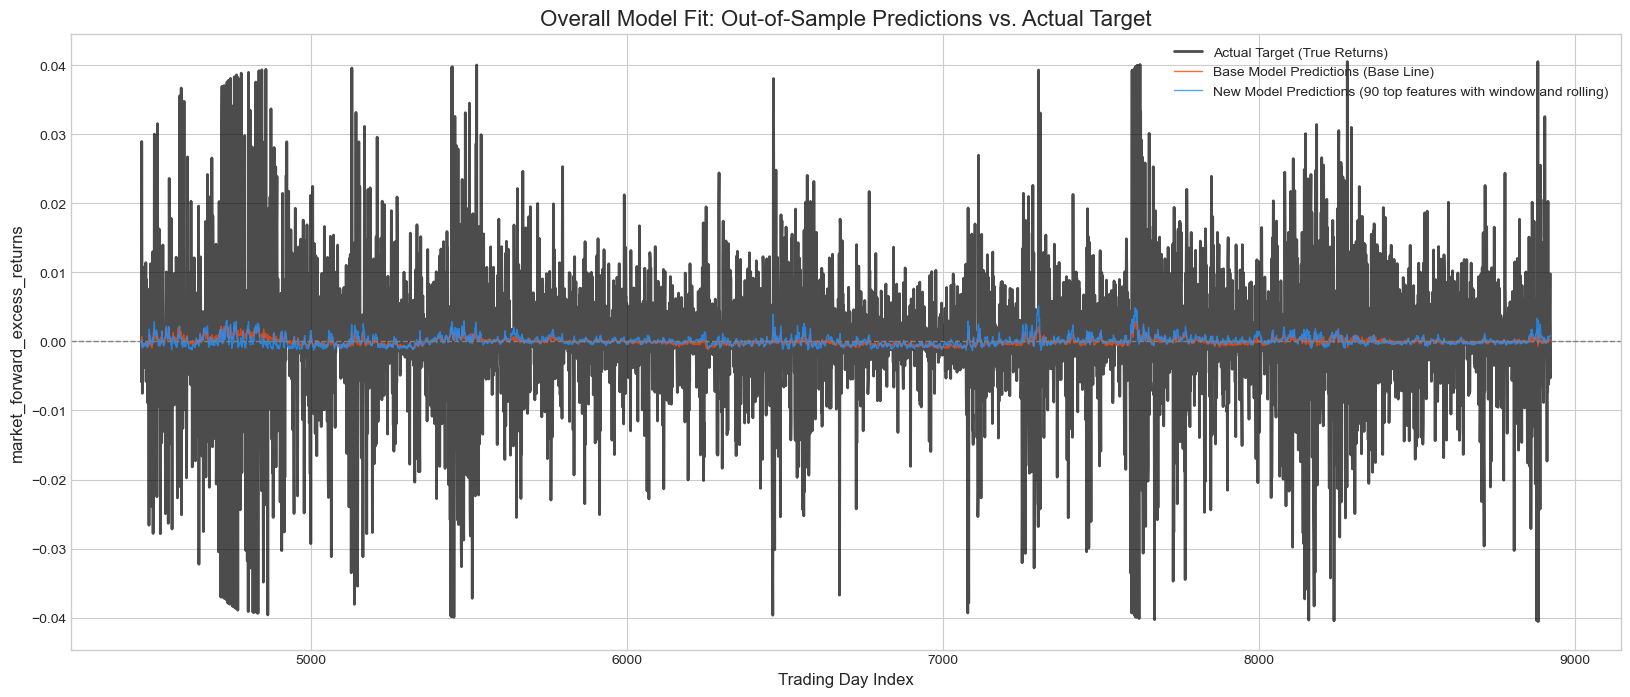


--- 正在生成累积收益拟合图 (权益曲线) ---

--- 正在为周期 1 生成累积收益图 ---


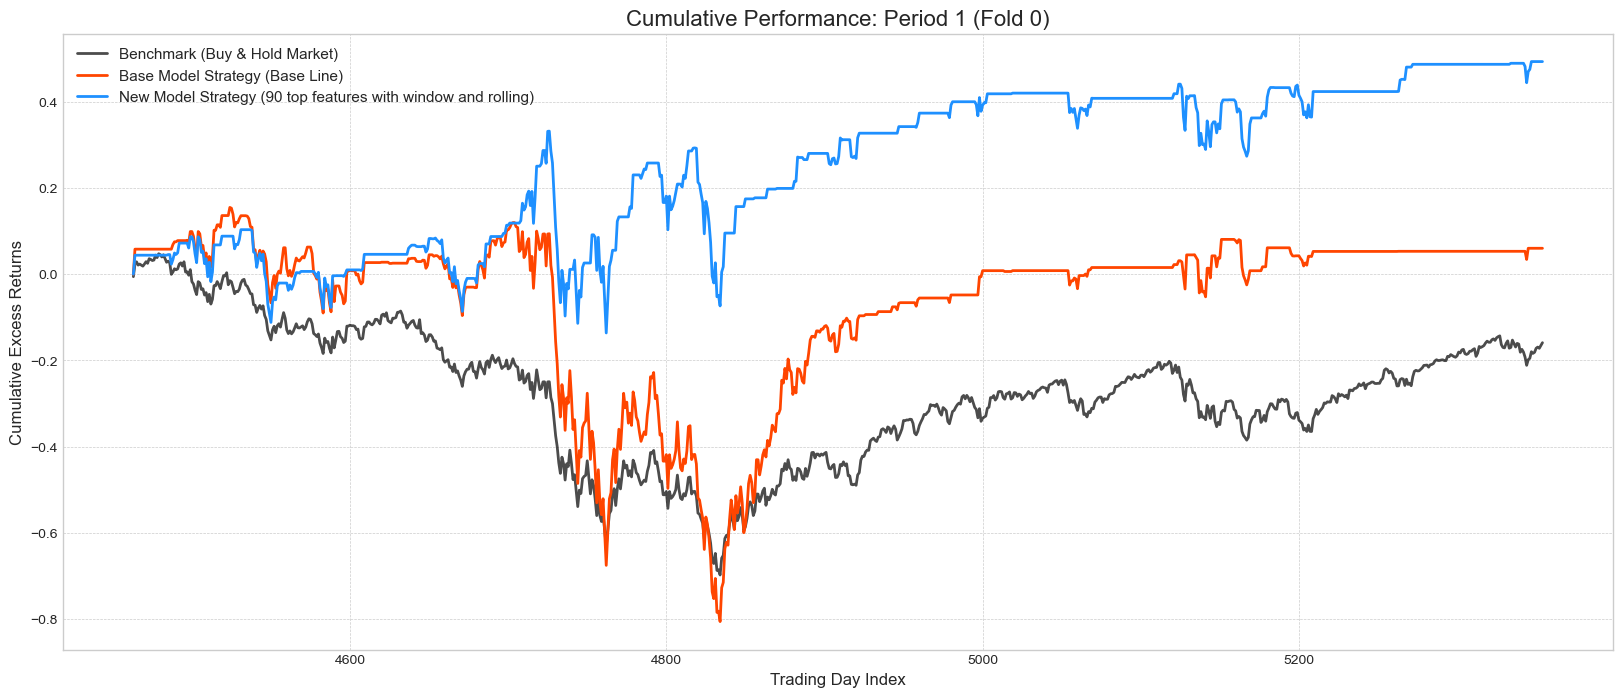


--- 正在为周期 2 生成累积收益图 ---


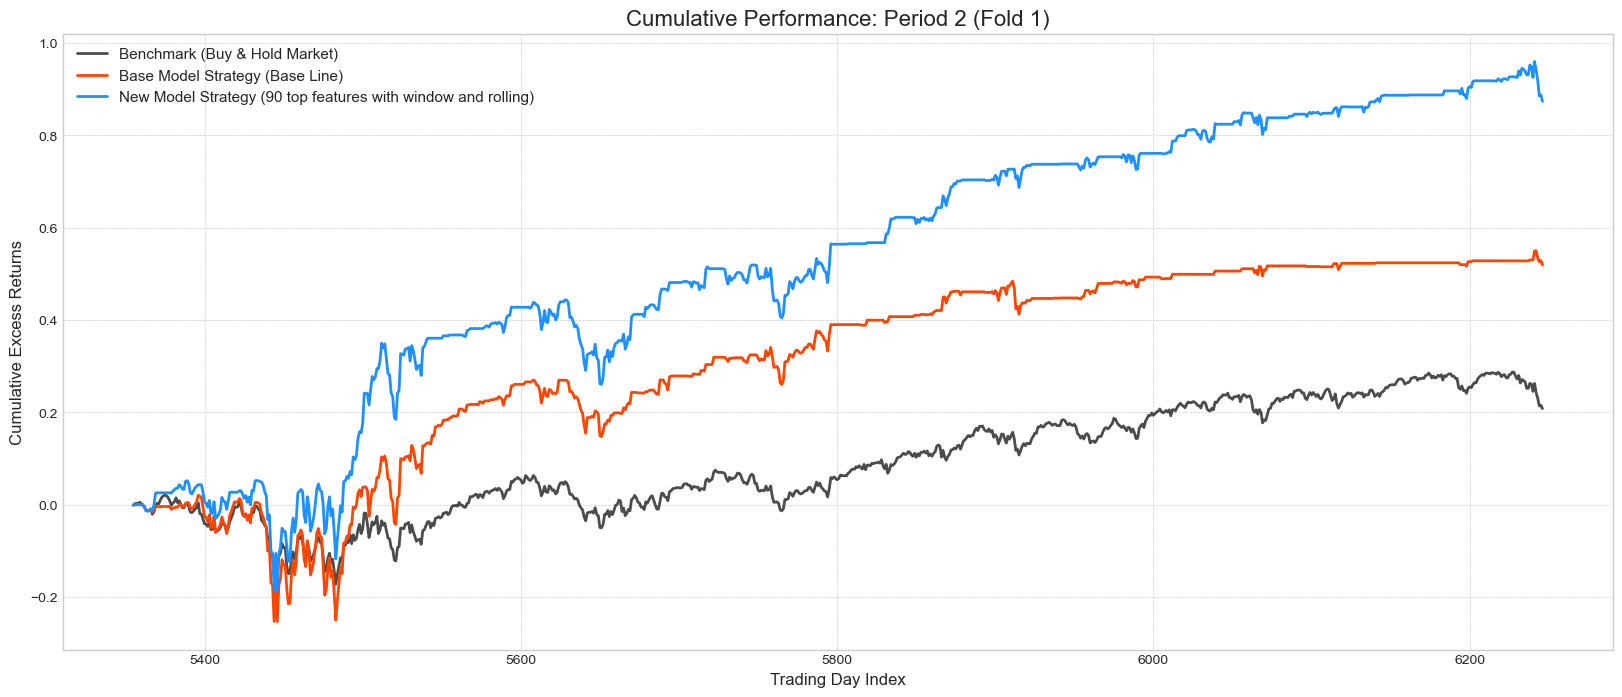


--- 正在为周期 3 生成累积收益图 ---


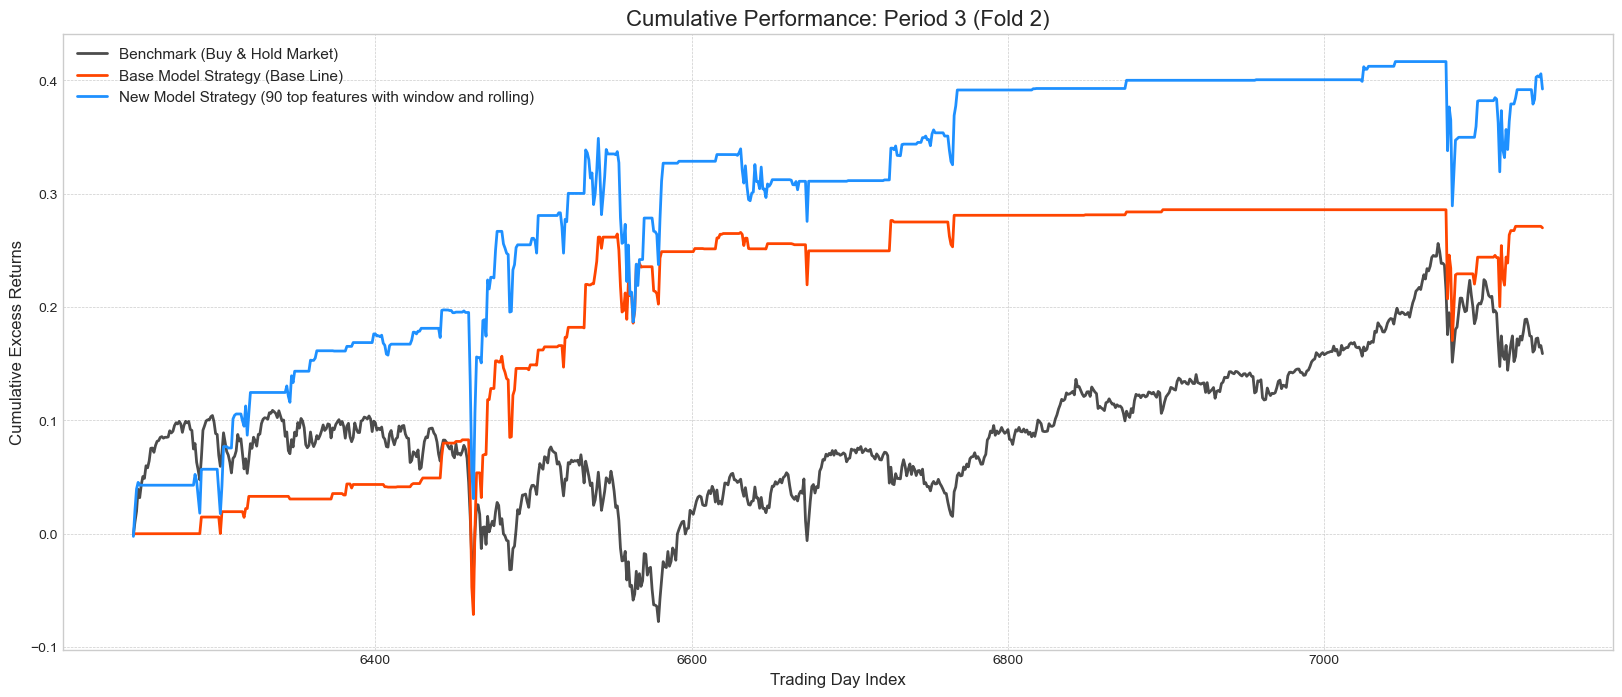


--- 正在为周期 4 生成累积收益图 ---


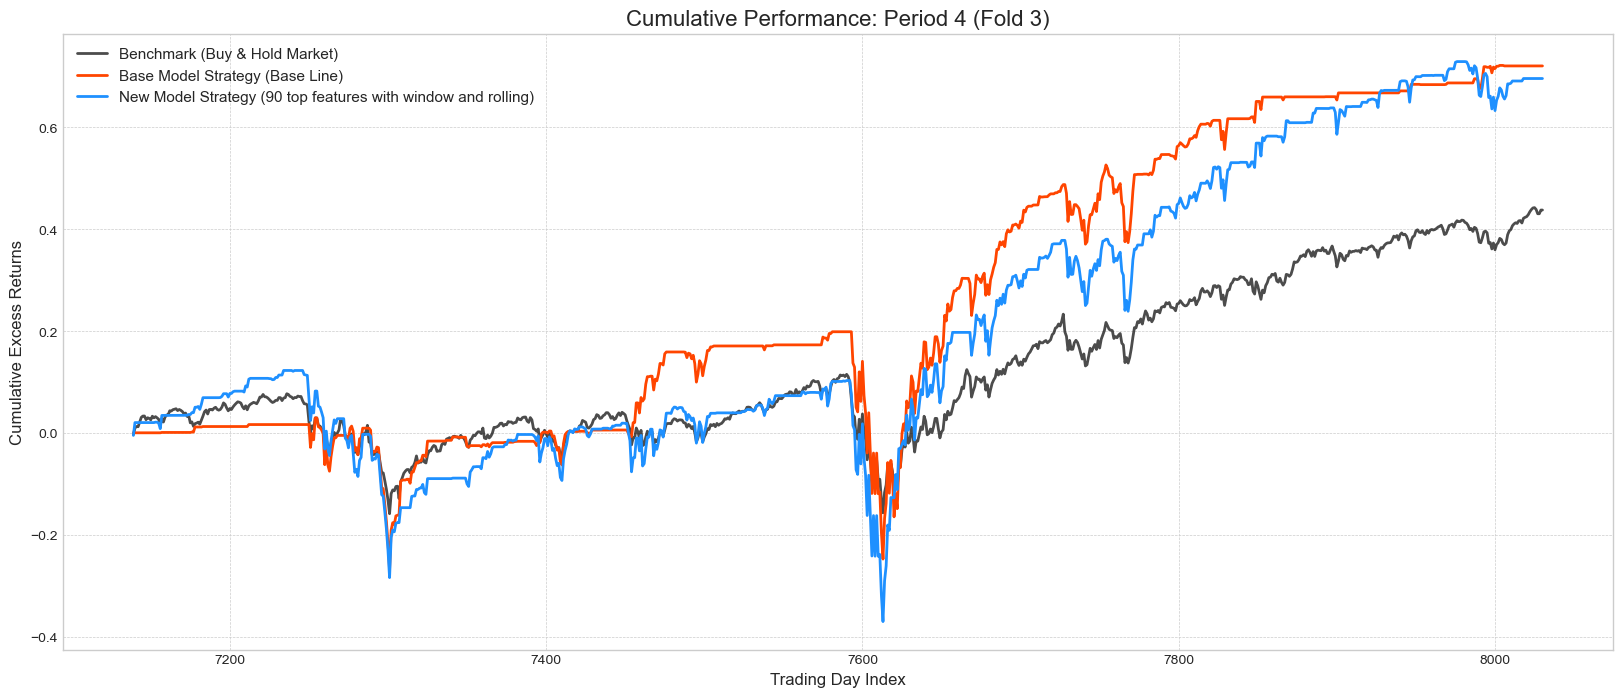


--- 正在为周期 5 生成累积收益图 ---


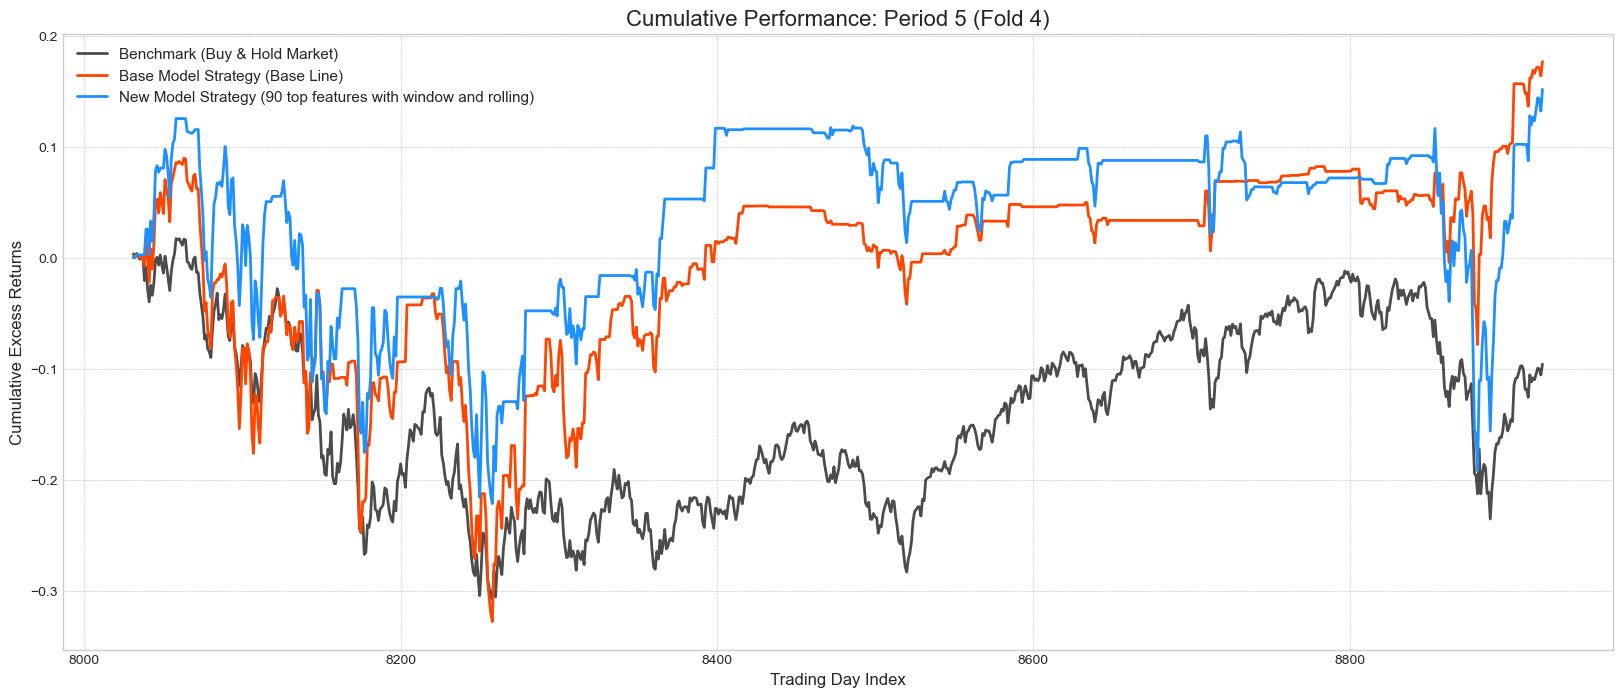

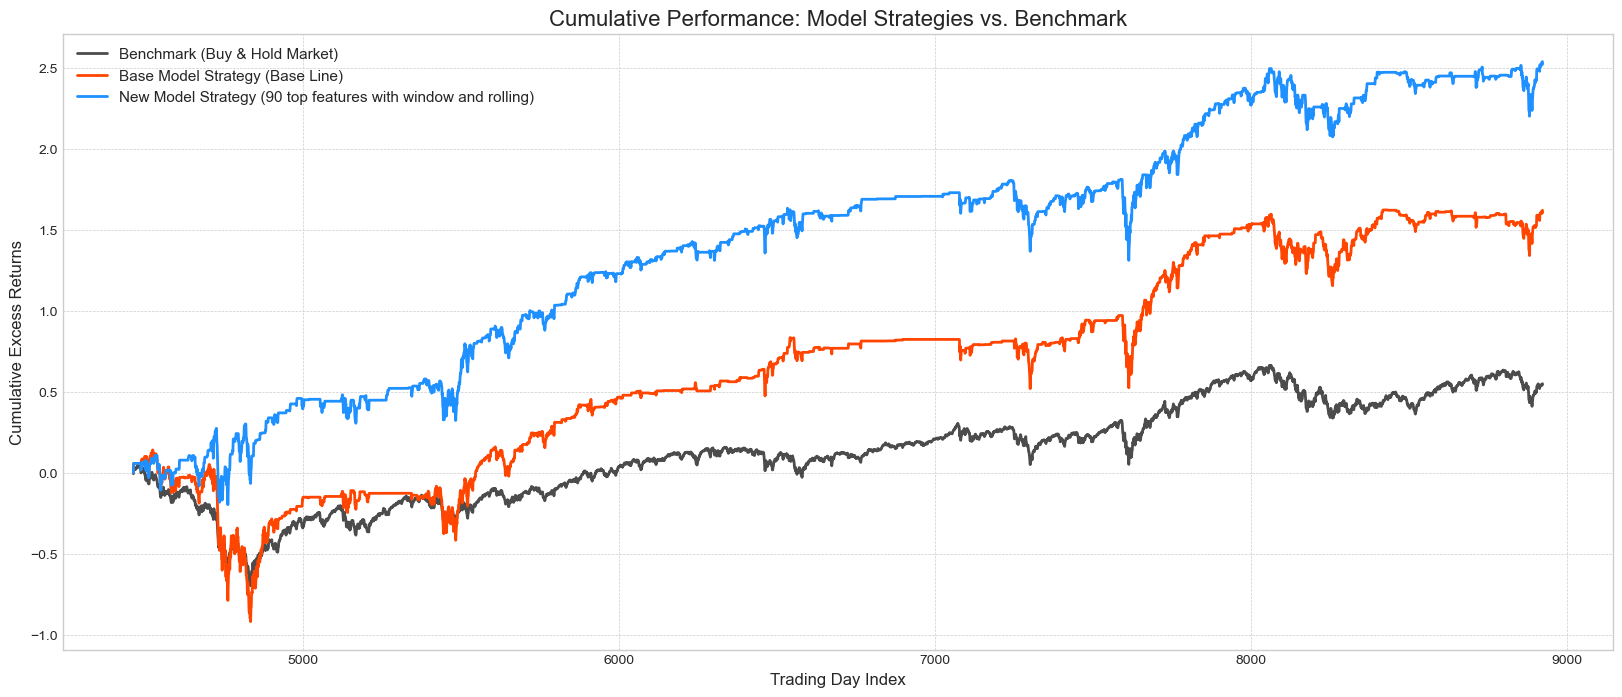

In [116]:
# --- 步骤 5: 拼接数据并绘制总体拟合图 ---

print("\n--- 正在生成总体拟合图 ---")

# 1. 将所有周期的测试数据拼接成一个连续的序列
if all_test_indices:
    combined_indices = np.concatenate(all_test_indices)
    combined_y_true = pd.Series(np.concatenate(all_y_true), index=combined_indices, name="Actual Target")
    combined_base_preds = pd.Series(np.concatenate(all_base_preds), index=combined_indices, name="Base Model Preds (fill 0)")
    combined_new_preds = pd.Series(np.concatenate(all_new_preds), index=combined_indices, name="New Model Preds (median)")

    # 2. 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))

    # 3. 绘制真实值和两个模型的预测值
    plt.plot(combined_y_true, label='Actual Target (True Returns)', color='black', linewidth=2, alpha=0.7)
    plt.plot(combined_base_preds, label=f'Base Model Predictions ({base_model_descirption})', color='orangered', linewidth=1, alpha=0.8)
    plt.plot(combined_new_preds, label=f'New Model Predictions ({new_model_descirption})', color='dodgerblue', linewidth=1, alpha=0.8)

    # 4. 添加图表元素
    plt.title('Overall Model Fit: Out-of-Sample Predictions vs. Actual Target', fontsize=16)
    plt.xlabel('Trading Day Index', fontsize=12)
    plt.ylabel(f'{TARGET}', fontsize=12)
    plt.legend(fontsize=10)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1) # 添加0线作为参考
    
    # 5. 显示图表
    plt.show()
    
print("\n--- 正在生成累积收益拟合图 (权益曲线) ---")

for i in range(len(all_test_indices)):
        print(f"\n--- 正在为周期 {i+1} 生成累积收益图 ---")
        # 1. 提取 *当前周期* 的数据
        period_indices = all_test_indices[i]
        period_y_true = all_y_true[i]
        period_base_preds = all_base_preds[i]
        period_new_preds = all_new_preds[i]
        
        # 2. 将 *当前周期* 的数据转换为 Pandas Series
        combined_y_true = pd.Series(period_y_true, index=period_indices, name="Actual Target")
        combined_base_preds = pd.Series(period_base_preds, index=period_indices, name="Base Model Preds")
        combined_new_preds = pd.Series(period_new_preds, index=period_indices, name="New Model Preds")

        # 3. 计算 *当前周期* 的策略收益
        #    (这部分逻辑与您之前的代码完全相同)
        
        # 基准策略: 买入并持有市场
        benchmark_returns = combined_y_true
        
        # 基础模型策略收益
        base_positions = np.where(combined_base_preds > 0, combined_base_preds*5000, 0)
        base_positions = np.clip(base_positions, 0, 2)
        base_strategy_returns = pd.Series(base_positions*benchmark_returns.values, index=benchmark_returns.index)
        
        # 新模型策略收益
        T = 0.0
        new_positions = np.where(combined_new_preds, combined_new_preds*5000, 0)
        new_positions = np.where(new_positions > T, new_positions, 0)
        new_positions = np.clip(new_positions, 0, 2)
        new_strategy_returns = pd.Series(new_positions*benchmark_returns.values, index=benchmark_returns.index)

        # 4. 计算 *当前周期* 的累积收益
        #    .cumsum() 会自动从 0 开始计算该周期的累积
        cumulative_benchmark = benchmark_returns.cumsum()
        cumulative_base_strategy = base_strategy_returns.cumsum()
        cumulative_new_strategy = new_strategy_returns.cumsum()

        # 5. 创建 *当前周期* 的图表
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(20, 8))

        # 6. 绘制三条累积收益曲线
        plt.plot(cumulative_benchmark, label='Benchmark (Buy & Hold Market)', color='black', linewidth=2, alpha=0.7)
        plt.plot(cumulative_base_strategy, label=f'Base Model Strategy ({base_model_descirption})', color='orangered', linewidth=2)
        plt.plot(cumulative_new_strategy, label=f'New Model Strategy ({new_model_descirption})', color='dodgerblue', linewidth=2)
        
        # 7. 添加图表元素 (使用动态标题)
        plt.title(f'Cumulative Performance: Period {i+1} (Fold {i})', fontsize=16)
        plt.xlabel('Trading Day Index', fontsize=12)
        plt.ylabel('Cumulative Excess Returns', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        # 8. 显示 *当前周期* 的图表
        #    plt.show() 在循环内部，所以每循环一次就显示一张图
        plt.show()
if all_test_indices:

    combined_indices = np.concatenate(all_test_indices)
    combined_y_true = pd.Series(np.concatenate(all_y_true), index=combined_indices, name="Actual Target")
    combined_base_preds = pd.Series(np.concatenate(all_base_preds), index=combined_indices, name="Base Model Preds")
    combined_new_preds = pd.Series(np.concatenate(all_new_preds), index=combined_indices, name="New Model Preds")
    # 2. 计算每个周期的策略收益
    # 基准策略: 买入并持有市场 (收益就是真实的目标值)
    benchmark_returns = combined_y_true

    # 基础模型策略收益 (根据 sharpe_ratio_scorer 的逻辑)
    base_positions = np.where(combined_base_preds > 0, combined_base_preds*10000, 0)
    base_positions = np.clip(base_positions, 0, 2)
    base_strategy_returns = pd.Series(base_positions*benchmark_returns.values, index=benchmark_returns.index)

    # 新模型策略收益
    T = 0.0
    new_positions = np.where(combined_new_preds, combined_new_preds*10000, 0)
    new_positions = np.where(new_positions > T, new_positions, 0)
    new_positions = np.clip(new_positions, 0, 2)
    new_strategy_returns = pd.Series(new_positions*benchmark_returns.values, index=benchmark_returns.index)

    # 3. 计算累积收益 (权益曲线)
    cumulative_benchmark = benchmark_returns.cumsum()
    cumulative_base_strategy = base_strategy_returns.cumsum()
    cumulative_new_strategy = new_strategy_returns.cumsum()

    # 4. 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))

    # 5. 绘制三条累积收益曲线
    plt.plot(cumulative_benchmark, label='Benchmark (Buy & Hold Market)', color='black', linewidth=2, alpha=0.7)
    plt.plot(cumulative_base_strategy, label=f'Base Model Strategy ({base_model_descirption})', color='orangered', linewidth=2)
    plt.plot(cumulative_new_strategy, label=f'New Model Strategy ({new_model_descirption})', color='dodgerblue', linewidth=2)

    # 6. 添加图表元素
    plt.title('Cumulative Performance: Model Strategies vs. Benchmark', fontsize=16)
    plt.xlabel('Trading Day Index', fontsize=12)
    plt.ylabel('Cumulative Excess Returns', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # 7. 显示图表

    plt.show() 

In [117]:
# ###############################################################
# ✅ 新增：解耦的“全局 SHAP 分析”部分
# ###############################################################

print("\n" + "="*50)
print("--- 正在执行 SHAP 全局分析 (基于所有样本外周期) ---")
print("="*50)

# 1. 合并所有周期的 X_val 数据
combined_X_val = pd.concat(all_X_val_new, axis=0)

# 2. 合并所有周期的 SHAP 值
#    (此方法适用于现代 SHAP Explanation 对象和旧的 NumPy 数组)
if hasattr(all_shap_values_new[0], 'values'):
    print("正在合并 SHAP Explanation 对象...")
    combined_shap_values = shap.utils.concatenate(all_shap_values_new)
    combined_shap_array = combined_shap_values.values
else:
    print("正在合并 NumPy SHAP 数组...")
    combined_shap_values = np.concatenate(all_shap_values_new, axis=0)
    combined_shap_array = combined_shap_values

print(f"全局 SHAP 分析基于 {combined_X_val.shape[0]} 个样本外数据点。")

# 3. 绘制全局 SHAP 条形图 (只绘制一次)
print("\n--- 正在生成全局 SHAP 条形图 ---")
shap.summary_plot(combined_shap_values, combined_X_val, plot_type="bar", max_display=100, show = False)
ax = plt.gca()
new_xlabel = "mean(|SHAP value|)"
ax.set_xlabel(new_xlabel, fontsize=9)
plt.tight_layout()
plt.show()

# 4. 运行全局 Top 15 依赖图分析 (只运行一次)
mean_abs_shap = np.abs(combined_shap_array).mean(axis=0)
feature_names = combined_X_val.columns
df_shap_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
})
df_shap_importance_sorted = df_shap_importance.sort_values(
    by='mean_abs_shap', ascending=False
).reset_index(drop=True)
with pd.option_context(
    'display.max_rows', None,    # <-- 关键：告诉 Pandas 显示所有行
    'display.max_columns', None, # <-- 关键：告诉 Pandas 显示所有列
    'display.width', 1000,       # <-- (可选) 加宽输出
    'display.precision', 8       # <-- (可选) 设置小数精度
):
    print(df_shap_importance_sorted)

top_40_features = df_shap_importance_sorted.head(40)['feature'].tolist()
print(top_40_features)

top_20_features = df_shap_importance_sorted.head(20)['feature']

print(f"\n--- 真正为全局 Top 20 特征生成依赖图 ---")
print(f"Top 20 特征: {top_20_features.tolist()}")


for feature_name in top_20_features:
    print(f"\n--- (全局) 正在分析 {feature_name} 的最强交互 ---")
    
    shap.dependence_plot(
        feature_name,
        combined_shap_values, # 传入合并后的 SHAP 对象/数组
        combined_X_val,       # 传入合并后的 DataFrame
        interaction_index="auto",
        show=False
    )
    plt.title(f"Global Dependence plot for {feature_name} (auto-interaction)")
    plt.show()

print("\n--- SHAP 分析完成 ---")


--- 正在执行 SHAP 全局分析 (基于所有样本外周期) ---
正在合并 NumPy SHAP 数组...


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 51 and the array at index 1 has size 52

In [ ]:
log2 = True 

print(f"\n开始执行单一时段分析...")
print(f"=== 目标: 计算 {new_model_descirption} 的 Top 20 交互组合 ===")

n_samples = len(X)
train_size = int(n_samples * 0.8) 
X_train, y_train = X.iloc[2000:train_size], y.iloc[2000:train_size]
X_val, y_val = X.iloc[train_size:], y.iloc[train_size:]

print(f"训练周期: index 2000 to {train_size-1} | 测试周期: index {train_size} to {n_samples-1}")


X_train_transformed2 = preprocessor_pipeline2.fit_transform(X_train)
model2.fit(X_train_transformed2, y_train)
X_val_transformed2 = preprocessor_pipeline2.transform(X_val)
preds_new = model2.predict(X_val_transformed2)
r2_val = r2_score(y_val, preds_new)
sharpe_val = ad_sharpe_ratio_scorer(preds_new, y_val) 
# ---

print(f"样本外 R² (R-squared): {r2_val:.4f}")
print(f"样本外夏普率 (Sharpe Ratio): {sharpe_val:.4f}")

print(f"--- 正在计算 SHAP 交互值 (这很慢)... ---")
try:
    explainer2 = shap.TreeExplainer(
        model2, 
        X_train_transformed2, # <-- 这是一个“大”数据集
        feature_perturbation="tree_path_dependent"
    )
except Exception as e:
    print(f"警告: 'tree_path_dependent' 失败: {e}")
    print("--- 正在尝试 'interventional' 作为备选方案 ---")
    try:
        explainer2 = shap.TreeExplainer(
            model2, 
            X_train_transformed2, 
            feature_perturbation="interventional"
        )
    except Exception as e2:
        print(f"致命错误: 无法初始化 Explainer: {e2}")
        # 在这里停止或引发错误

# --- 
# 4. ✅ 计算 *缓慢* 的 SHAP 交互值 (3D)
# ---
try: 
    combined_interaction_values = explainer2.shap_interaction_values(X_val_transformed2)
    combined_X_val = X_val_transformed2 # (我们现在只有一个 X_val)
    
    # ----------------------------------------------------
    # 5. ✅ 最终分析：计算并打印 Top 20 交互组合
    # ----------------------------------------------------
    print("\n" + "="*50)
    print(f"--- 正在计算 {new_model_descirption} 的 Top 50 全局 [交互组合] ---")
    print("="*50)
    
    interaction_matrix = np.abs(combined_interaction_values).mean(axis=0)
    np.fill_diagonal(interaction_matrix, 0) # 移除自我交互

    features = combined_X_val.columns
    n_features = len(features)

    interaction_pairs = []
    for i in range(n_features):
        for j in range(i + 1, n_features): 
            interaction_strength = interaction_matrix[i, j]
            interaction_pairs.append({
                "feature_1": features[i],
                "feature_2": features[j],
                "strength": interaction_strength
            })

    df_interactions = pd.DataFrame(interaction_pairs)
    df_top_50_interactions = df_interactions.sort_values(
        by="strength", ascending=False
    ).head(50).reset_index(drop=True)

    print("\n--- 模型的 Top 50 最佳交互组合 (全局) ---")
    print(df_top_50_interactions)

# ---
# ✅ 修正 1: 添加这个缺失的 'except' 块
# ---
except Exception as e:
    print(f"\n--- 交互组合 (Interactions) 分析失败 ---")
    print(f"致命错误: {e}")
    # 我们可以检查 explainer2 是否被成功创建
    if 'explainer2' not in locals():
        print("错误详情: Explainer 对象 'explainer2' 未被成功初始化。")
    else:
        print(f"Explainer 类型: {type(explainer2)}")


开始执行单一时段分析...
=== 目标: 计算 90 top features with window and rolling 的 Top 20 交互组合 ===
训练周期: index 2000 to 7140 | 测试周期: index 7141 to 8926


Model is not converging.  Current: 79386.51609730821 is not greater than 79392.84755675263. Delta is -6.331459444423672
Model is not converging.  Current: 52237.16014978574 is not greater than 52265.148691553266. Delta is -27.98854176752502
Model is not converging.  Current: 52237.16014978574 is not greater than 52265.148691553266. Delta is -27.98854176752502
Model is not converging.  Current: 87424.94049664034 is not greater than 87426.23895780294. Delta is -1.2984611626015976
Model is not converging.  Current: 87424.94049664034 is not greater than 87426.23895780294. Delta is -1.2984611626015976
Model is not converging.  Current: 119337.6640880001 is not greater than 119338.62295187311. Delta is -0.9588638730056118
Model is not converging.  Current: 119337.6640880001 is not greater than 119338.62295187311. Delta is -0.9588638730056118
Model is not converging.  Current: 114065.61645265571 is not greater than 114066.31269699325. Delta is -0.6962443375377916
Model is not converging.  Cur


Optimal number of regimes (bic): 8


Model is not converging.  Current: 200818.68947107674 is not greater than 200822.30953995464. Delta is -3.6200688779063057
Model is not converging.  Current: 207649.14853691234 is not greater than 207651.5990187127. Delta is -2.4504818003624678
Model is not converging.  Current: 207649.14853691234 is not greater than 207651.5990187127. Delta is -2.4504818003624678
Model is not converging.  Current: 216465.32978539242 is not greater than 216471.48763286622. Delta is -6.157847473805305
Model is not converging.  Current: 216465.32978539242 is not greater than 216471.48763286622. Delta is -6.157847473805305


("Feature X: ['M4_roll_mean_5', 'M4', 'V13', 'M4_lag_1', 'S12', "
 "'forward_returns_lag_roll_mean_5', 'S5_lag_1', 'S5_roll_mean_20', "
 "'forward_returns_lag', 'I2', 'S2', 'P7', 'P5', 'M17', 'S2_lag_1', "
 "'feat_M4_div_V13', 'M2', 'S5', 'V7', 'S5_roll_mean_60', 'S2_roll_std_60', "
 "'M17_lag_1', 'V12', 'M17_lag_5', 'M11', 'forward_returns_lag_lag_1', 'M8', "
 "'M17_lag_20', 'S2_roll_mean_5', 'S2_roll_mean_20', 'E19_roll_std_5', 'E11', "
 "'P10', 'V8', 'forward_returns_lag_roll_mean_60', 'M17_roll_mean_20', 'M12', "
 "'E11_roll_std_20', 'E11_lag_20', 'S5_roll_mean_5', 'regime_0_prob', "
 "'regime_1_prob', 'regime_2_prob', 'regime_3_prob', 'regime_4_prob', "
 "'regime_5_prob', 'regime_6_prob', 'regime_7_prob']")
Feature Creator Output Shape: (5141, 48)
样本外 R² (R-squared): 0.0011
样本外夏普率 (Sharpe Ratio): 0.0220
--- 正在计算 SHAP 交互值 (这很慢)... ---
警告: 'tree_path_dependent' 失败: 'TreeEnsemble' object has no attribute 'values'
--- 正在尝试 'interventional' 作为备选方案 ---
致命错误: 无法初始化 Explainer: 'TreeEnsemb

In [ ]:
''' Final testify
X_test_transformed1 = preprocessor_pipeline1.transform(X_test)
X_test_transformed2 = preprocessor_pipeline2.transform(X_test)
preds_base = model1.predict(X_test_transformed1)
preds_new = model2.predict(X_test_transformed2)

base_model_sharpe_scores = ad_sharpe_ratio_scorer(preds_base, y_test)
new_model_sharpe_scores = ad_sharpe_ratio_scorer(preds_new, y_test)
base_model_r2_scores = r2_score(y_test, preds_base)
new_model_r2_scores = r2_score(y_test, preds_new)
base_model_hit_rate = np.mean(np.sign(y_test) == np.sign(preds_base))
new_model_hit_rate = np.mean(np.sign(y_test) == np.sign(preds_new))

print(f"基础模型在各周期的夏普率: {base_model_sharpe_scores}")
print(f"新模型在各周期的夏普率:  {base_model_sharpe_scores} ")
print("-" * 50)
print(f"基础模型在各周期的 R²: {base_model_r2_scores}")
print(f"新模型在各周期的 R²:  {new_model_r2_scores}")
print("-" * 50)
print(f"基础模型在各周期的 hit_rate: {base_model_hit_rate}")
print(f"新模型在各周期的 hit_rate:   {new_model_hit_rate}")


benchmark_returns = y_test
    
# 基础模型策略收益 (根据 sharpe_ratio_scorer 的逻辑)
base_positions = np.where(preds_base > 0, preds_base*5000, 0)
base_positions = np.clip(base_positions, 0, 2)
base_strategy_returns = pd.Series(base_positions*benchmark_returns.values, index=benchmark_returns.index)
    
# 新模型策略收益
T = 0.0
new_positions = np.where(preds_new, preds_new*5000, 0)
new_positions = np.where(new_positions > T, new_positions, 0)
new_positions = np.clip(new_positions, 0, 2)
with np.printoptions(precision=3, suppress=True):
    print(new_positions)
new_strategy_returns = pd.Series(new_positions*benchmark_returns.values, index=benchmark_returns.index)
    
# 3. 计算累积收益 (权益曲线)
cumulative_benchmark = benchmark_returns.cumsum()
cumulative_base_strategy = base_strategy_returns.cumsum()
cumulative_new_strategy = new_strategy_returns.cumsum()

# 4. 创建图表
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(20, 8))

    # 5. 绘制三条累积收益曲线
plt.plot(cumulative_benchmark, label='Benchmark (Buy & Hold Market)', color='black', linewidth=2, alpha=0.7)
plt.plot(cumulative_base_strategy, label=f'Base Model Strategy ({base_model_descirption})', color='orangered', linewidth=2)
plt.plot(cumulative_new_strategy, label=f'New Model Strategy ({new_model_descirption})', color='dodgerblue', linewidth=2)
    
    # 6. 添加图表元素
plt.title('Cumulative Performance: Model Strategies vs. Benchmark', fontsize=16)
plt.xlabel('Trading Day Index', fontsize=12)
plt.ylabel('Cumulative Excess Returns', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # 7. 显示图表
plt.show()
'''

' Final testify\nX_test_transformed1 = preprocessor_pipeline1.transform(X_test)\nX_test_transformed2 = preprocessor_pipeline2.transform(X_test)\npreds_base = model1.predict(X_test_transformed1)\npreds_new = model2.predict(X_test_transformed2)\n\nbase_model_sharpe_scores = ad_sharpe_ratio_scorer(preds_base, y_test)\nnew_model_sharpe_scores = ad_sharpe_ratio_scorer(preds_new, y_test)\nbase_model_r2_scores = r2_score(y_test, preds_base)\nnew_model_r2_scores = r2_score(y_test, preds_new)\nbase_model_hit_rate = np.mean(np.sign(y_test) == np.sign(preds_base))\nnew_model_hit_rate = np.mean(np.sign(y_test) == np.sign(preds_new))\n\nprint(f"基础模型在各周期的夏普率: {base_model_sharpe_scores}")\nprint(f"新模型在各周期的夏普率:  {base_model_sharpe_scores} ")\nprint("-" * 50)\nprint(f"基础模型在各周期的 R²: {base_model_r2_scores}")\nprint(f"新模型在各周期的 R²:  {new_model_r2_scores}")\nprint("-" * 50)\nprint(f"基础模型在各周期的 hit_rate: {base_model_hit_rate}")\nprint(f"新模型在各周期的 hit_rate:   {new_model_hit_rate}")\n\n\nbenchmark_returns = y_te